<a href="https://colab.research.google.com/github/yosbel-penate/AppEFThreading/blob/master/T2V_LSTM_KalmanFilter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pykalman mlflow



In [ ]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_error

from typing import Tuple, Dict

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import os

from mlflow import log_metric, log_param, log_artifacts

import warnings
warnings.filterwarnings("ignore")

from pykalman import KalmanFilter

In [ ]:
CRIPTO = 'ADAEUR'
VELAS = '15m'
log_param("moneda", CRIPTO)
log_param("velas", VELAS)

SEQUENCE_LENGHT = 100

param = {
    'unit': 50,
    't2v_dim': 50,
    'lr': 1e-2, 
    'act': 'relu', 
    'epochs': 10,
    'batch_size': 100
}


In [ ]:
df = pd.read_csv('ADAEUR_15m_1 Jan, 2019_to_19 Mar, 2021.csv')

In [ ]:
df.shape

(12023, 7)

In [ ]:
df.head()

,start,open,high,low,close,volume,trades
0,2020-11-13 10:00:00,0.08945,0.09079,0.08945,0.09068,29196.0,22.0
1,2020-11-13 10:15:00,0.09075,0.09075,0.09064,0.09064,2765.5,3.0
2,2020-11-13 10:30:00,0.09052,0.09052,0.09052,0.09052,1858.2,1.0
3,2020-11-13 10:45:00,0.09045,0.09046,0.09045,0.09046,650.7,3.0
4,2020-11-13 11:00:00,0.09039,0.09039,0.09038,0.09038,553.0,3.0


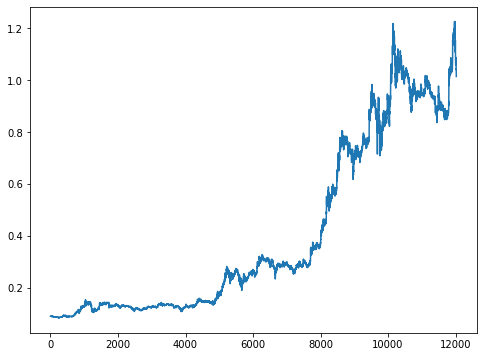

In [ ]:
df['close'].plot( figsize=(8,6))

In [ ]:

def KalmanTransform(df: pd.DataFrame,variable: str = 'close') -> None:
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean =df['{}'.format(variable)].values.mean(),
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.05)
    state_means, _ = kf.filter(df[variable].values)
    df['kalman'] = pd.Series(state_means.flatten(), index=df.index)

In [ ]:
df_tmp=df.copy()

kf = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean =df_tmp['close'].values.mean(),
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.05)
state_means, _ = kf.filter(df_tmp['close'].values)
df_tmp['kalman'] = pd.Series(state_means.flatten(), index=df.index)

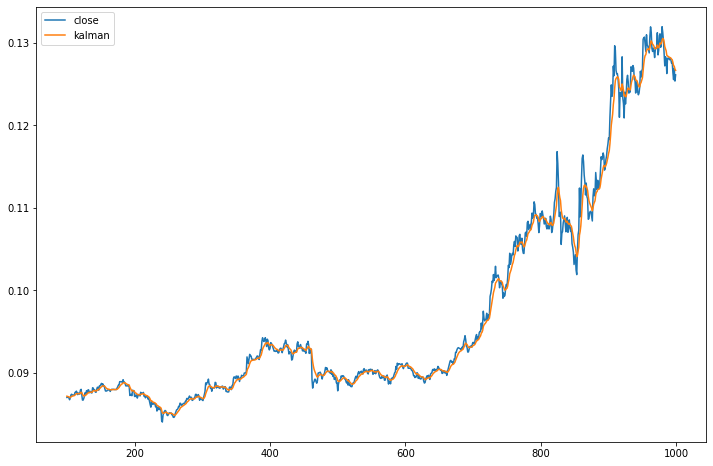

In [ ]:
df_tmp[['close','kalman']][100:1000].plot(figsize=(12,8))

https://www.cienciadedatos.net/images/transform_timeseries.gif

In [ ]:

def gen_sequence(id_df: pd.DataFrame, seq_length: int, seq_cols: str):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        


def gen_labels(id_df: pd.DataFrame, seq_length: int, label: str):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]


Paper: https://arxiv.org/pdf/1907.05321.pdf




In [ ]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)


### CREATE GENERATOR FOR LSTM AND T2V ###


def T2V_NN(param: Dict, dim: int = SEQUENCE_LENGHT):
    for key in param:
        log_param(key, param[key])
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m




In [ ]:

### PREPARE DATA TO FEED MODELS ###
def PrepareData(df: pd.DataFrame, KALMAN: bool = False, predict_variable: str = 'close', sequence_length: int = SEQUENCE_LENGHT)-> Tuple:
    X, Y = [], []
    log_param("kalman", KALMAN)
    log_param('sequence_length',sequence_length)
    if KALMAN:
        KalmanTransform(df, predict_variable)
        for sequence in gen_sequence(df, sequence_length, ['kalman']):
            X.append(sequence)
    else:
        for sequence in gen_sequence(df, sequence_length, [predict_variable]):
            X.append(sequence)

    for sequence in gen_labels(df, sequence_length, [predict_variable]):
        Y.append(sequence)

    X = np.asarray(X)
    Y = np.asarray(Y)



    ### TRAIN TEST SPLIT ###

    train_dim = int(0.7*len(df))
    X_train, X_test = X[:train_dim], X[train_dim:]
    y_train, y_test = Y[:train_dim], Y[train_dim:]

    print('Train shape X: '+str(X_train.shape)+' y: '+str(y_train.shape))
    print('Test shape X: '+str(X_test.shape)+' y: '+str(y_test.shape))
    return (X_train,X_test,y_train,y_test)


In [ ]:


### DEFINE PARAM GRID FOR HYPERPARM OPTIMIZATION ###



m=T2V_NN(param)
print(m.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
t2v_1 (T2V)                  (None, 100, 51)           5250      
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 25,701
Trainable params: 25,701
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_train,X_test,y_train,y_test=PrepareData(df,KALMAN=False)

Train shape X: (8416, 100, 1) y: (8416, 1)
Test shape X: (3507, 100, 1) y: (3507, 1)


In [ ]:
m.fit(X_train,y_train, batch_size=param['batch_size'],epochs=param['epochs'])

Epoch 1/10
85/85 [==============================] - 9s 83ms/step - loss: 0.0071
Epoch 2/10
85/85 [==============================] - 7s 87ms/step - loss: 1.1917e-05
Epoch 3/10
85/85 [==============================] - 7s 86ms/step - loss: 1.0501e-05
Epoch 4/10
85/85 [==============================] - 7s 86ms/step - loss: 1.2408e-05
Epoch 5/10
85/85 [==============================] - 7s 86ms/step - loss: 1.0888e-05
Epoch 6/10
85/85 [==============================] - 7s 86ms/step - loss: 1.2189e-05
Epoch 7/10
85/85 [==============================] - 7s 86ms/step - loss: 1.3931e-05
Epoch 8/10
85/85 [==============================] - 7s 85ms/step - loss: 1.1706e-05
Epoch 9/10
85/85 [==============================] - 7s 86ms/step - loss: 9.6787e-06
Epoch 10/10
85/85 [==============================] - 7s 86ms/step - loss: 1.1588e-05


In [ ]:
pred = m.predict(X_test).ravel()


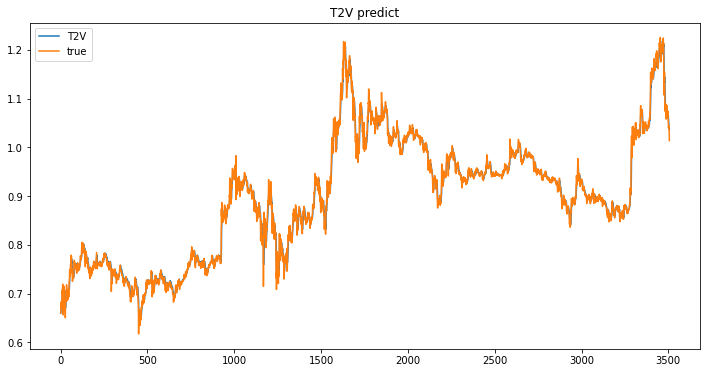

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(pred, label='T2V')
plt.plot(y_test.ravel(), label='true')
plt.title('T2V predict'); plt.legend()

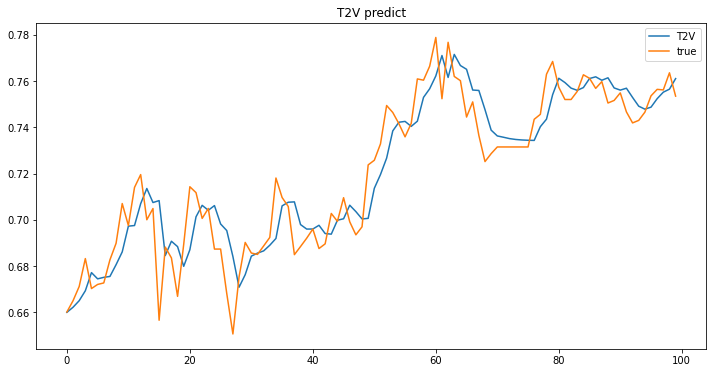

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(pred[:100], label='T2V')
plt.plot(y_test[:100].ravel(), label='true')
plt.title('T2V predict'); plt.legend()

In [ ]:
print(mean_absolute_error(y_test.ravel(), pred))
log_metric("MAE",mean_absolute_error(y_test.ravel(), pred)) 

0.006770525533650584


In [ ]:
!mlflow ui

[2021-04-10 08:54:29 +0000] [996] [INFO] Starting gunicorn 20.1.0
[2021-04-10 08:54:29 +0000] [996] [INFO] Listening at: http://127.0.0.1:5000 (996)
[2021-04-10 08:54:29 +0000] [996] [INFO] Using worker: sync
[2021-04-10 08:54:29 +0000] [999] [INFO] Booting worker with pid: 999
[2021-04-10 08:54:56 +0000] [996] [INFO] Handling signal: int

Aborted!
[2021-04-10 08:54:56 +0000] [999] [INFO] Worker exiting (pid: 999)
[2021-04-10 08:54:57 +0000] [996] [INFO] Shutting down: Master
